## Create Dataset for Sentiment Analysis

### Setup
    Install the required packages and setup the imports.

In [1]:
!pip install -qq google-play-scraper

In [2]:
!pip install -qq -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.12.0

pandas             : 1.1.1
matplotlib         : 3.3.3
seaborn            : 0.11.1
google_play_scraper: 0.1.2



In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Let's choose some apps that fit the criteria from the Productivity category. We'll use [AppAnnie](https://www.appannie.com/account/login/?next=%2Fapps%2Fgoogle-play%2Ftop-chart%3Fcountry%3DUS%26category%3D29%26device%3D%26date%3D2020-04-05%26feed%3DAll%26rank_sorting_type%3Drank%26page_number%3D1%26page_size%3D100%26table_selections%3D) to select some of the top US apps:

In [5]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

## Scraping App Information
- Lets scrape the info for each app

In [6]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='us')
    del info['comments']
    app_infos.append(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:33<00:00,  2.25s/it]


We get info for all 15 apps. Lets write the helper function that prints JSON objects a bit better.


In [7]:
def print_json(json_object):
    json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
    )
    print(highlight)

In [8]:
# Here is a sample app information from the list:
print_json(app_infos[0])

<function highlight at 0x000001C13E3A39D8>


This contains lots of information inculuding the number of ratings, number of reviews and number of ratings for each score(1 to 5). Lets have a look at the icons 

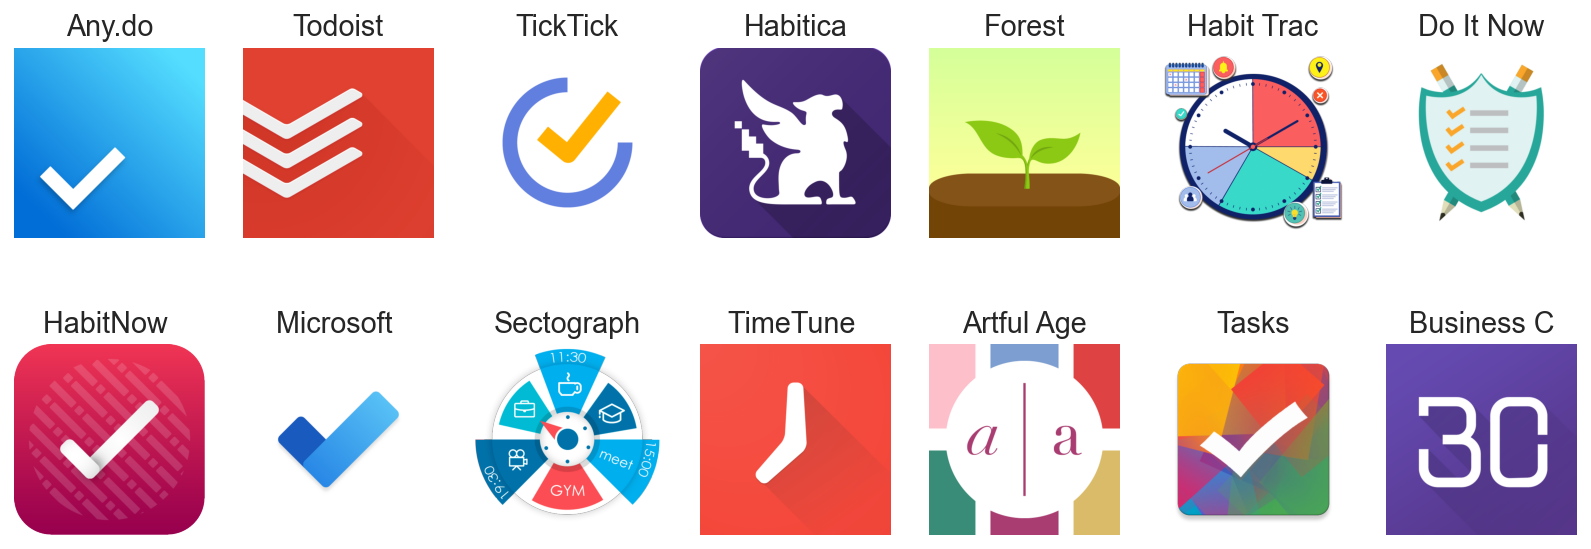

In [9]:
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

We'll store the app information for later by converting the JSON objects into pandas dataframe and saving the result into a csv file 

In [10]:
app_info_df = pd.DataFrame(app_infos)
app_info_df.to_csv('apps.csv', index=None, header=True)

## Scraping App Reviews
We want:
- Balanced dataset - roughly tha same number of reviews for each score(1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [12]:
app_reviews = []
for ap in tqdm(app_packages):
    for score in list(range(1,6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
            ap,
            lang='en',
            country='us',
            sort=sort_order,
            count=200 if score == 3 else 100,
            filter_score_with=score)
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:49<00:00, 11.28s/it]


In [13]:
print_json(app_reviews[0])

<function highlight at 0x000001C13E3A39D8>


In [14]:
len(app_reviews)

16402

In [15]:
# Lets save the reviews to csv file:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

## Summary
We have a dataset with more than 16k reviews from 15 productivity apps.

### Read data for analysis

In [16]:
# Read csv file
import pandas as pd
data = pd.read_csv('reviews.csv')
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFZ-MWENdh24H_g0qGDAVUkrdFEJoNaYudcwe2...,Don White,https://play-lh.googleusercontent.com/-3dOQZya...,"January 2021: In short..I'm done, and moving o...",1,179,5.7.0.20,2021-01-15 19:55:27,We're are doing our best to fix any issues and...,2021-01-18 19:41:54,most_relevant,com.anydo
1,gp:AOqpTOEidRmDaHGYPZW21SVfBkeqTruAzg7LAmCPL2_...,Michelle Armstrong,https://play-lh.googleusercontent.com/a-/AOh14...,I downloaded this because of the cross platfor...,1,84,5.7.0.20,2020-12-23 00:01:11,The Premium ad only shows up when first openin...,2020-12-24 01:28:46,most_relevant,com.anydo
2,gp:AOqpTOEcWS_b8b4P2gClKovxXAPg3il0AD0ZnGw9RxY...,H G,https://play-lh.googleusercontent.com/-2Zyc1Oz...,Unable to use it as it won't work with my Goog...,1,16,5.7.0.20,2021-01-11 06:42:58,"As our team explained profusely, we sync data ...",2021-01-10 18:28:09,most_relevant,com.anydo
3,gp:AOqpTOEJfVU5Os7_8CNOu_mpy2AlDz8kFxEFMeBMnxC...,Yiğitcan Sümbelli,https://play-lh.googleusercontent.com/a-/AOh14...,I am starting to hate this app! Every time the...,1,69,5.7.0.10,2020-12-02 21:22:24,"Hi, please note that these issues usually are ...",2020-12-04 02:17:02,most_relevant,com.anydo
4,gp:AOqpTOFSPaoOVarqwKF86e7-TPUyV6BanSXKRNFGb6G...,Jon Pember,https://play-lh.googleusercontent.com/-97UNn5D...,"Liked Any.do at first, enough that I even sign...",1,104,5.7.0.10,2020-11-23 05:12:56,Please note that Any.do integrates directly wi...,2020-11-25 19:00:01,most_relevant,com.anydo


In [17]:
# select columns for review analysis
review_score = data[['content', 'score']]

In [18]:
review_score

,content,score
0,"January 2021: In short..I'm done, and moving o...",1
1,I downloaded this because of the cross platfor...,1
2,Unable to use it as it won't work with my Goog...,1
3,I am starting to hate this app! Every time the...,1
4,"Liked Any.do at first, enough that I even sign...",1
...,...,...
16397,"It's good, recommended it",5
16398,This is the best planner app I've come across ...,5
16399,"This is a wonderful reminder, especially to th...",5
16400,Useful and easy to use. :),5


###  Select reviews which has rating 5

In [19]:
rating_5 = review_score[review_score['score'] == 5]
rating_5.head()

,content,score
1000,"The app itself is fantastic, and the customer ...",5
1001,"I love this app, it looks stunning and clean w...",5
1002,I usually don't use planner apps as they can b...,5
1003,Better than ever!!! So many new features and a...,5
1004,It is an interesting app for those who like to...,5


### Preprocessing
In NLP, text preprocessing is the first step in the process of building a model.
The various steps in preprocessing are-
- Tokenization
- Lower casing
- Special characters removal
- Stop words removal
- Stemming
- Lemmatization

In [20]:
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy
from collections import Counter

In [21]:
# Initialize  Spacy 'en' model(language)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
# create new column and convert to lower case
rating_5['new_reviews_5'] = rating_5['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
rating_5['new_reviews_5'].head()                                                      

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1000    the app itself is fantastic, and the customer ...
1001    i love this app, it looks stunning and clean w...
1002    i usually don't use planner apps as they can b...
1003    better than ever!!! so many new features and a...
1004    it is an interesting app for those who like to...
Name: new_reviews_5, dtype: object

In [23]:
# Next, we will remove punctuation:
rating_5['new_reviews_5'] = rating_5['new_reviews_5'].str.replace('[^\w\s]','')
rating_5['new_reviews_5'].head()

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1000    the app itself is fantastic and the customer s...
1001    i love this app it looks stunning and clean wh...
1002    i usually dont use planner apps as they can be...
1003    better than ever so many new features and app ...
1004    it is an interesting app for those who like to...
Name: new_reviews_5, dtype: object

In [24]:
# Stopwords removal
stop = stopwords.words('english')
rating_5['new_reviews_5'] = rating_5['new_reviews_5'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

rating_5.head(10)

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,content,score,new_reviews_5
1000,"The app itself is fantastic, and the customer ...",5,app fantastic customer service world extremely...
1001,"I love this app, it looks stunning and clean w...",5,love app looks stunning clean personally impor...
1002,I usually don't use planner apps as they can b...,5,usually dont use planner apps quite confusing ...
1003,Better than ever!!! So many new features and a...,5,better ever many new features app integration ...
1004,It is an interesting app for those who like to...,5,interesting app like get things done enjoys vi...
1005,"It's an amazing app, I tried various apps that...",5,amazing app tried various apps good well one n...
1006,Its really good. There are features i wish you...,5,really good features wish would add like due d...
1007,I've been using this app for a long time now. ...,5,ive using app long time bad memorie app make r...
1008,Love it!! It did take some playing around to f...,5,love take playing around fully understand feat...
1009,Useful app. I purchased the paid version and i...,5,useful app purchased paid version worth price ...


In [25]:
# Apply lemmatization using Spacy so that we can count the appearance of each word.  Lemmatization removes the grammar tense and transforms each word into its original form.
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])

rating_5['new_reviews_5'] = rating_5['new_reviews_5'].apply(space)
rating_5.head()

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,content,score,new_reviews_5
1000,"The app itself is fantastic, and the customer ...",5,app fantastic customer service world extremely...
1001,"I love this app, it looks stunning and clean w...",5,love app look stunning clean personally import...
1002,I usually don't use planner apps as they can b...,5,usually do not use planner app quite confusing...
1003,Better than ever!!! So many new features and a...,5,well ever many new feature app integration new...
1004,It is an interesting app for those who like to...,5,interesting app like get thing do enjoy visual...


## Wordcloud cloud for reviews with rating 5

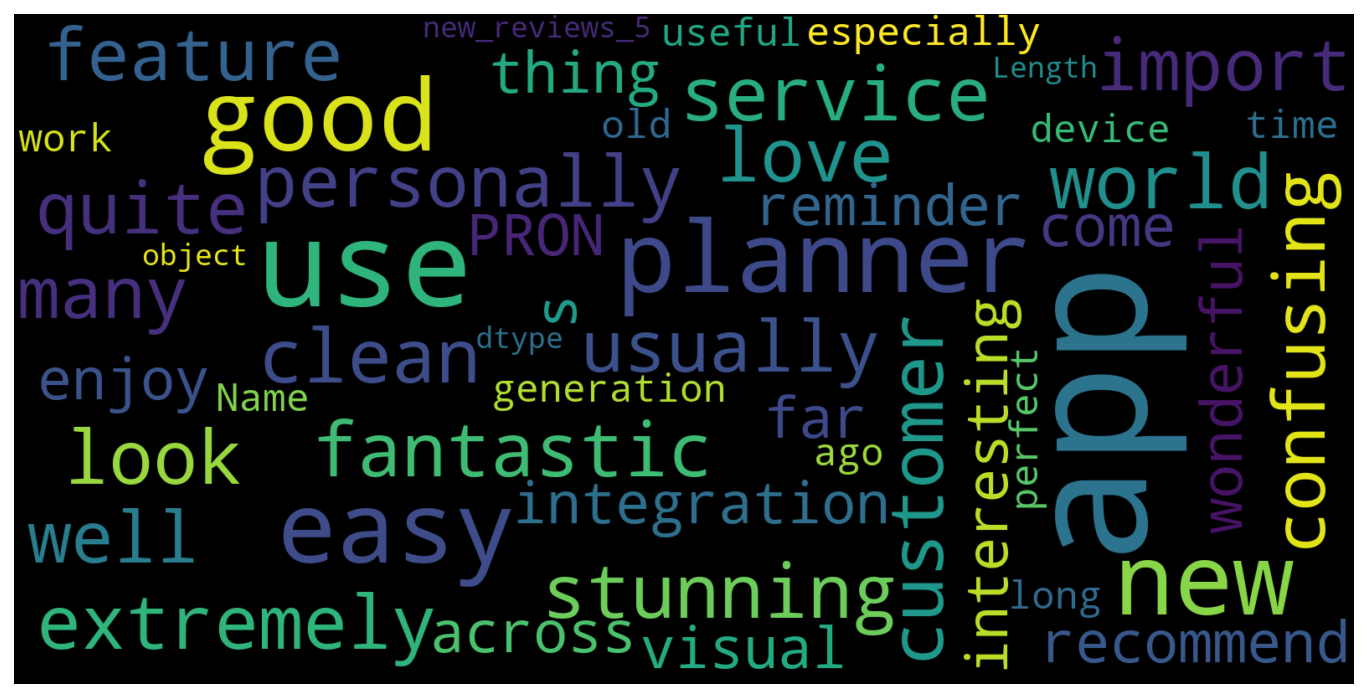

In [26]:
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(rating_5['new_reviews_5']))
                                                                          
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Select reviews which has rating 1


In [27]:
rating_1 = review_score[review_score['score'] == 1]
rating_1.head()

,content,score
0,"January 2021: In short..I'm done, and moving o...",1
1,I downloaded this because of the cross platfor...,1
2,Unable to use it as it won't work with my Goog...,1
3,I am starting to hate this app! Every time the...,1
4,"Liked Any.do at first, enough that I even sign...",1


In [28]:
# create new column and convert to lower case
rating_1['new_reviews_1'] = rating_1['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
rating_1['new_reviews_1'].head()                                                      

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    january 2021: in short..i'm done, and moving o...
1    i downloaded this because of the cross platfor...
2    unable to use it as it won't work with my goog...
3    i am starting to hate this app! every time the...
4    liked any.do at first, enough that i even sign...
Name: new_reviews_1, dtype: object

In [29]:
# Next, we will remove punctuation:
rating_1['new_reviews_1'] = rating_1['new_reviews_1'].str.replace('[^\w\s]','')
rating_1['new_reviews_1'].head()

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    january 2021 in shortim done and moving on fro...
1    i downloaded this because of the cross platfor...
2    unable to use it as it wont work with my googl...
3    i am starting to hate this app every time they...
4    liked anydo at first enough that i even signed...
Name: new_reviews_1, dtype: object

In [30]:
# Stopwords removal
stop = stopwords.words('english')
rating_1['new_reviews_1'] = rating_1['new_reviews_1'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))
rating_1.head(10)

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,content,score,new_reviews_1
0,"January 2021: In short..I'm done, and moving o...",1,january 2021 shortim done moving anydo one go ...
1,I downloaded this because of the cross platfor...,1,downloaded cross platform syncing purchase app...
2,Unable to use it as it won't work with my Goog...,1,unable use wont work google calendar tech supp...
3,I am starting to hate this app! Every time the...,1,starting hate app every time update start exac...
4,"Liked Any.do at first, enough that I even sign...",1,liked anydo first enough even signed premium c...
5,They made me sign up for premium just to have ...,1,made sign premium recurring alerts dont even h...
6,I paid premium for years. No more! This app ha...,1,paid premium years app become unreliable rando...
7,I'm using the free version and it is nothing y...,1,im using free version nothing everything part ...
8,What happened?? I have this app installed on m...,1,happened app installed phone works beautifully...
9,"It's a good app, but for gods sake, I do not c...",1,good app gods sake care pop ups telling add th...


In [31]:
# Apply lemmatization using Spacy so that we can count the appearance of each word.  Lemmatization removes the grammar tense and transforms each word into its original form.
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])

rating_1['new_reviews_1'] = rating_1['new_reviews_1'].apply(space)
rating_1.head()

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,content,score,new_reviews_1
0,"January 2021: In short..I'm done, and moving o...",1,january 2021 shortim do move anydo one go app ...
1,I downloaded this because of the cross platfor...,1,downloaded cross platform syncing purchase app...
2,Unable to use it as it won't work with my Goog...,1,unable use will not work google calendar tech ...
3,I am starting to hate this app! Every time the...,1,start hate app every time update start exact p...
4,"Liked Any.do at first, enough that I even sign...",1,liked anydo first enough even sign premium cou...


## Wordcloud cloud for reviews with rating 1


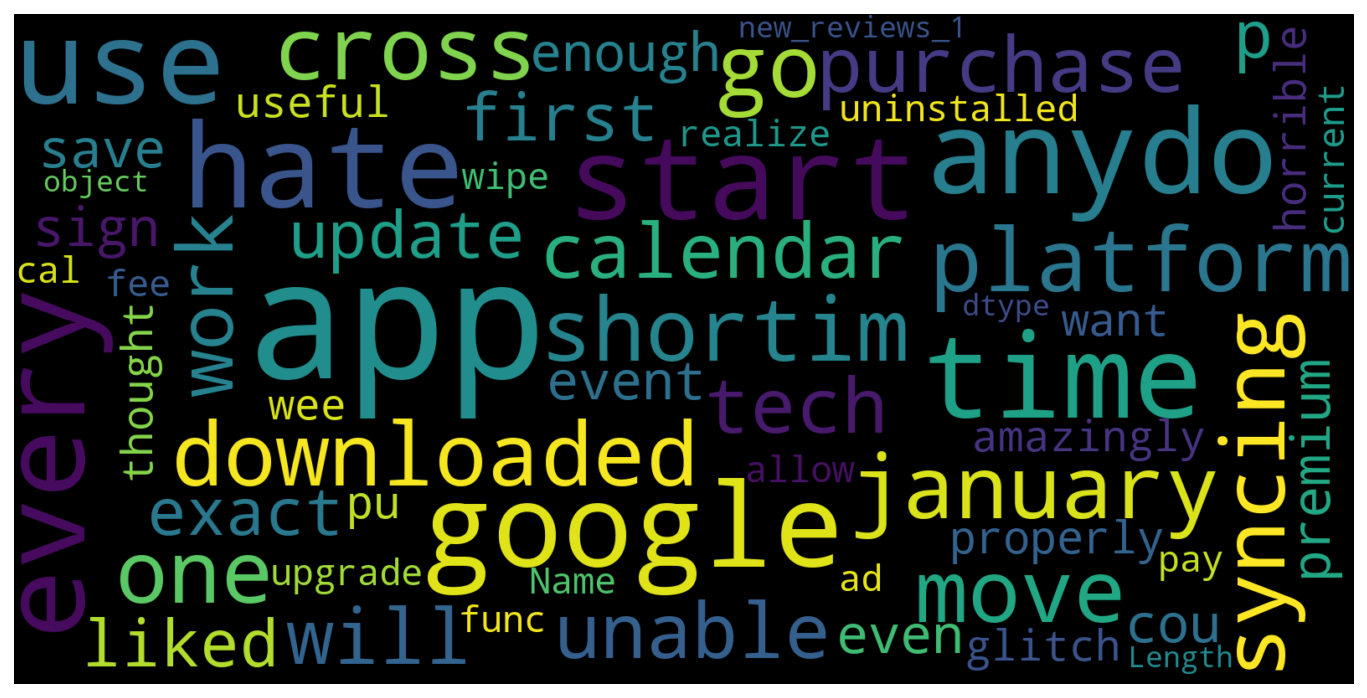

In [36]:
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(rating_1['new_reviews_1']))
                                                                          
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()